### Business problem

Effective inventory and sales management are critical for optimizing profitability in the retail and wholesale industry. Companies need to ensure that they are not incurring losses due to inefficient pricing, poor inventory turnover or vendor dependency. The goal of this analysis is to:

*	Identify underperforming brands that require promotional or pricing adjustments.
*	Determine top vendors contributing to sales and gross profit.
*	Analyse the impact of bulk purchasing on unit costs.
*	Assess inventory turnover to reduce holding costs and improve efficiency.
*	Investigate the profitability variance between high-performing and low-performing vendors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sqlalchemy import create_engine,text
from configure import DB_CONFIG # import database information from config.py to maintain security user and password

# Create the SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{DB_CONFIG["username"]}:{DB_CONFIG["password"]}@{DB_CONFIG["host"]}:{DB_CONFIG["port"]}/{DB_CONFIG["database"]}")

connection = engine.connect()

# Test the Connection
print("✅ Connected to MySQL successfully!")

✅ Connected to MySQL successfully!


In [3]:
df = pd.read_sql_query("SELECT * FROM vendors_sales_summary",connection)
df['vendor_name'] = df['vendor_name'].str.strip().str.title()
df.head(5)

,vendor_id,vendor_name,vendor_rating,active_status,product_id,product_name,category,total_orders,total_units_purchased,total_purchase_amount,...,total_units_returned,invoice_count,total_invoice_amount,avg_invoice_amount,avg_discount_given,avg_late_penalty,Gross_Profit,Profit_Margin,Stock_Turnover,Sales_Purchase_Ratio
0,497,Rush Llc,3.3,Active,1,Philips Microwave Oven – Red,Home Appliances,5,2856,1179908.11,...,18,192,57470652.53,299326.32,17018.75,93.49,25229.27,2.09,0.68,1.02
1,493,Blackburn-Mitchell,2.8,Active,1,Philips Microwave Oven – Red,Home Appliances,2,900,397188.00,...,3,180,58417705.52,324542.81,17919.27,98.75,9796.84,2.41,0.74,1.02
2,492,Roman-Zavala,4.0,Active,1,Philips Microwave Oven – Red,Home Appliances,1,496,225789.12,...,5,228,76317991.32,334728.03,18313.40,102.10,33212.71,12.82,0.83,1.15
3,490,Arnold Ltd,3.7,Inactive,1,Philips Microwave Oven – Red,Home Appliances,2,1902,803652.06,...,23,210,62499059.31,297614.57,15573.79,100.23,217419.84,21.29,0.87,1.27
4,488,"Malone, Rowe And Weaver",3.1,Inactive,1,Philips Microwave Oven – Red,Home Appliances,3,615,277452.08,...,7,165,49452575.87,299712.58,16717.16,97.48,47077.74,14.51,0.84,1.17


### Exploratory Data Analysis

* Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

* In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [4]:
# Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,55841.0,2.501881e+02,1.447858e+02,1.00,124.00,250.00,375.00,500.00
vendor_rating,55841.0,3.734057e+00,7.407216e-01,2.50,3.10,3.80,4.30,5.00
product_id,55841.0,2.505343e+02,1.442544e+02,1.00,126.00,251.00,376.00,500.00
total_orders,55841.0,1.790799e+00,1.044824e+00,1.00,1.00,1.00,2.00,12.00
total_units_purchased,55841.0,9.888418e+02,7.569425e+02,100.00,466.00,785.00,1322.00,8552.00
total_purchase_amount,55841.0,5.475911e+05,4.824726e+05,19592.99,222657.23,405812.95,703743.25,6939548.19
avg_purchase_amount,55841.0,3.063808e+05,1.822077e+05,19592.99,161351.41,269572.81,422807.25,939227.75
purchase_status_delivered,55841.0,1.524597e+00,1.116002e+00,0.00,1.00,1.00,2.00,10.00
purchase_status_pending,55841.0,1.744059e-01,5.709738e-01,0.00,0.00,0.00,0.00,8.00
purchase_status_canceled,55841.0,9.179635e-02,4.189172e-01,0.00,0.00,0.00,0.00,7.00


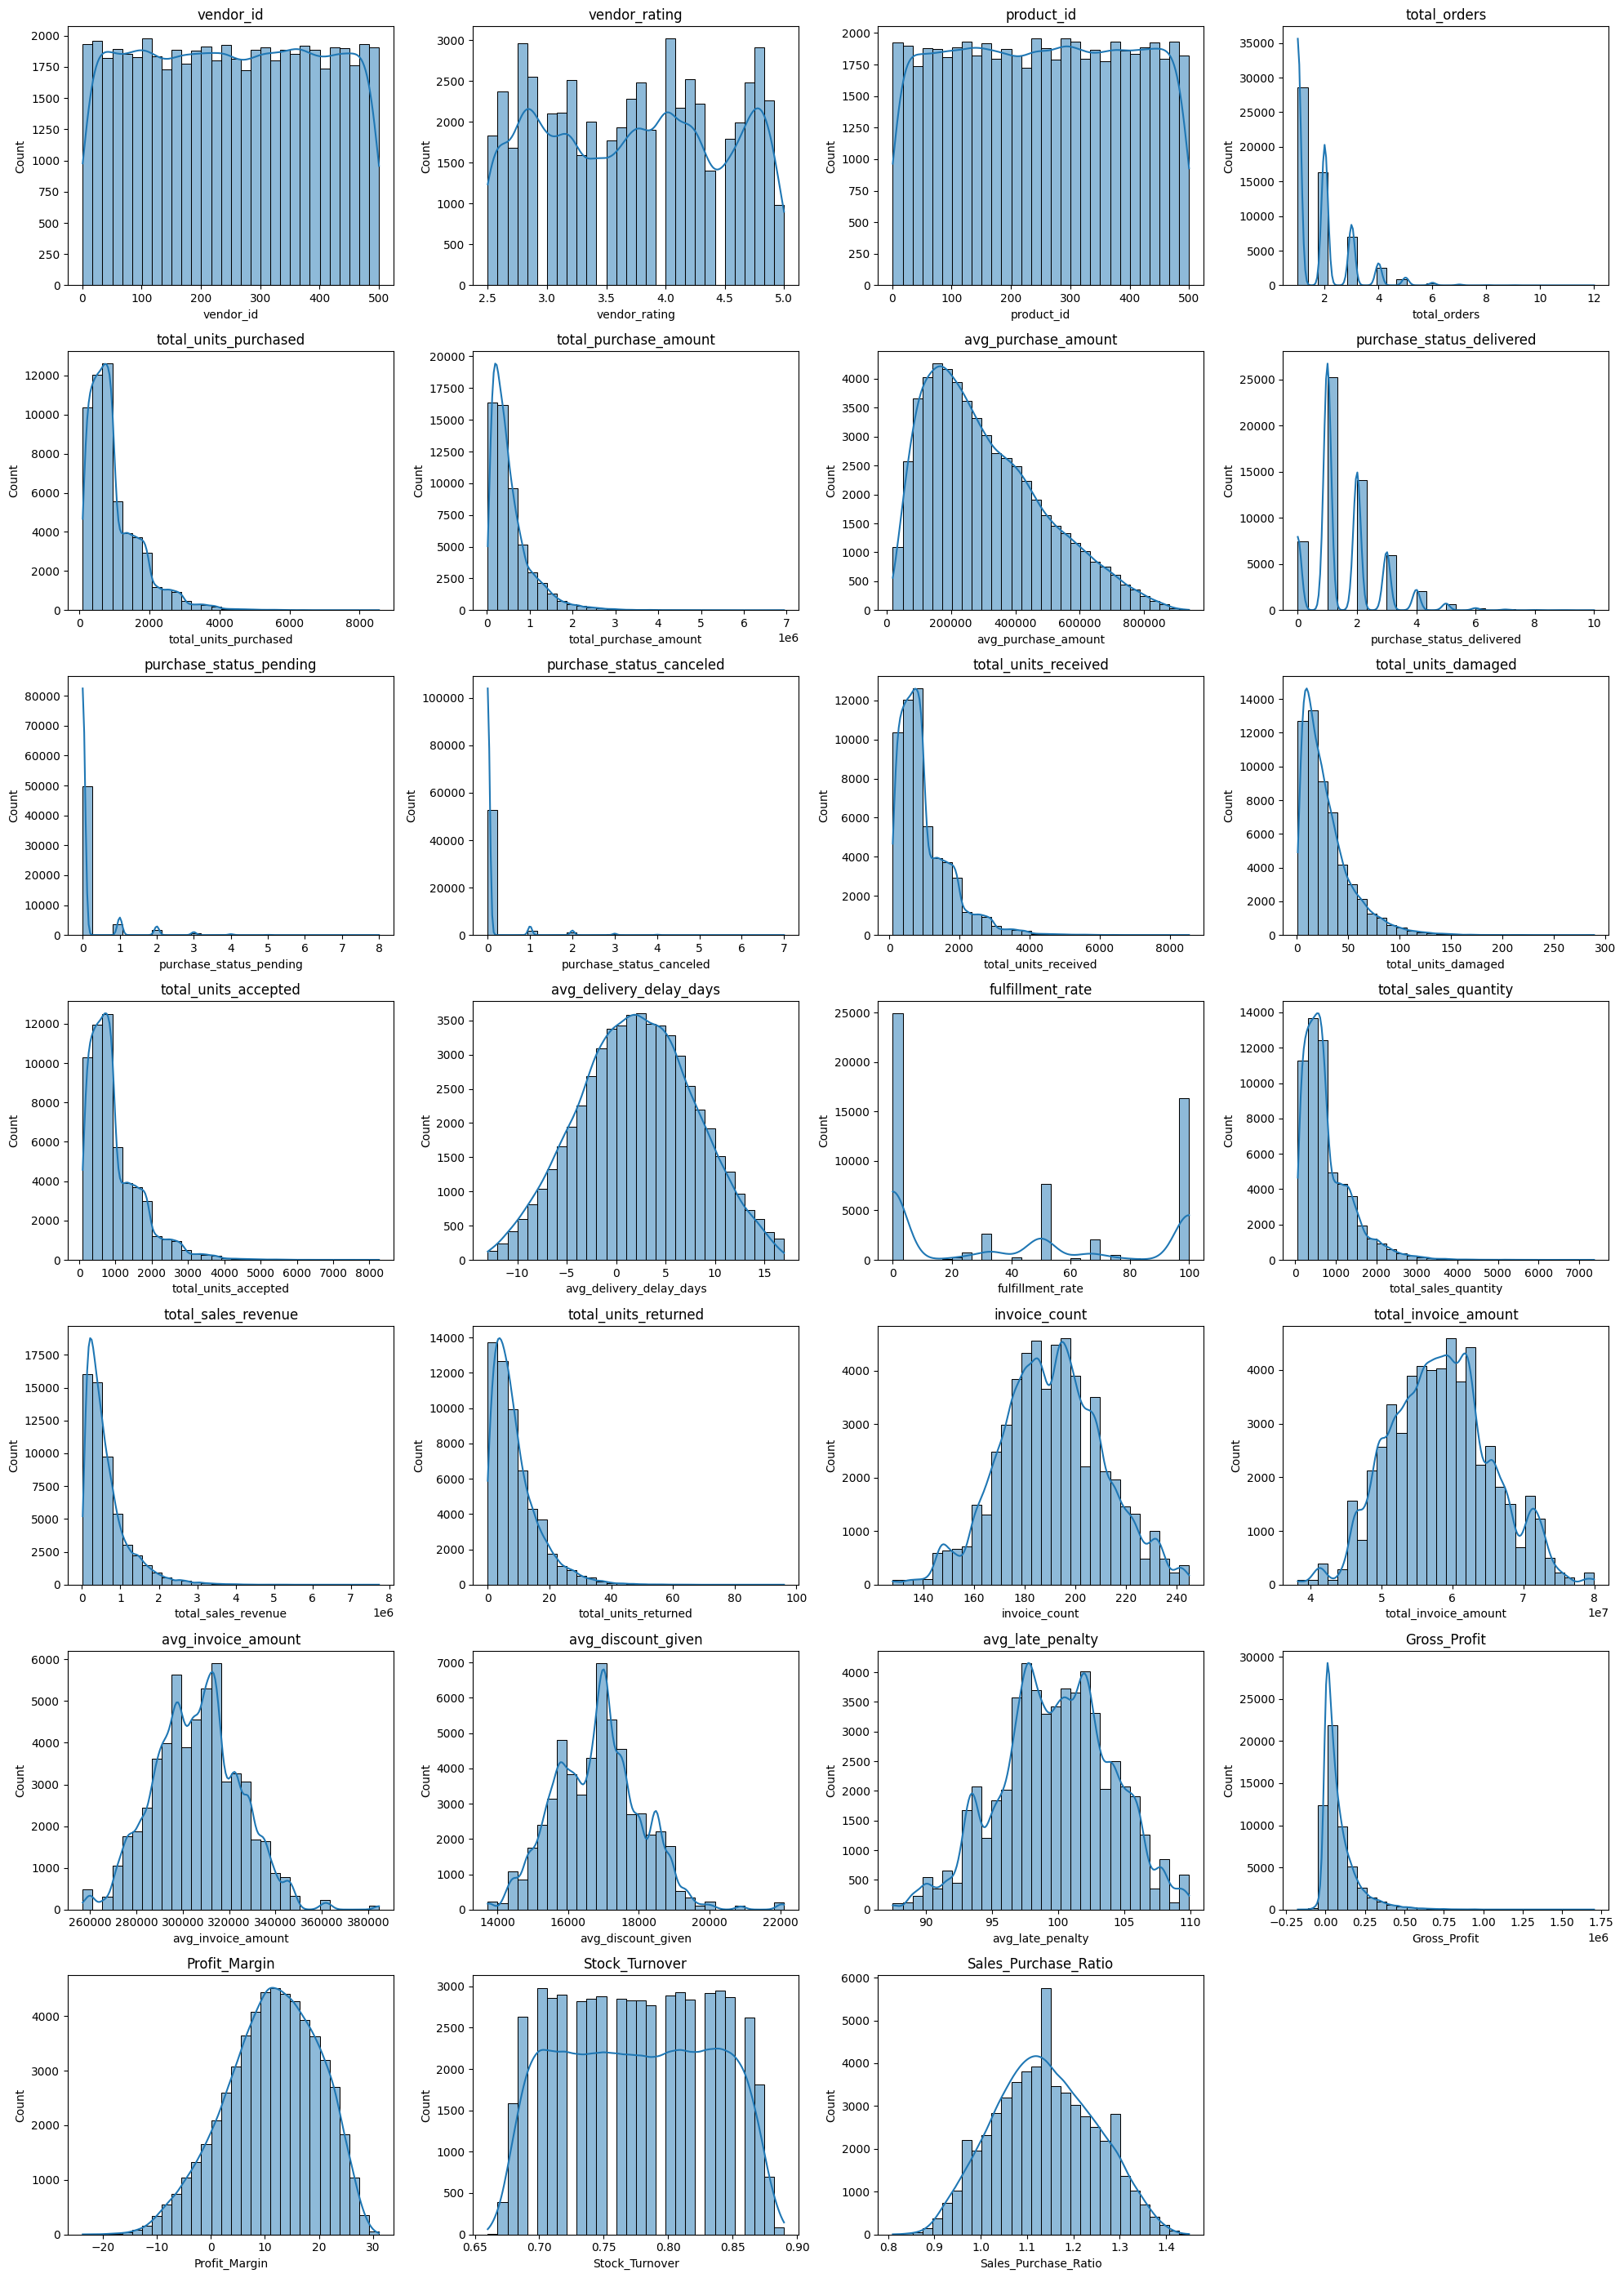

In [5]:
# Distributtion Plots for Numerical columns

numerical_cols = df.select_dtypes(include=np.number).columns
num_cols = len(numerical_cols)

# dynamically calculate grid size
n_cols = 4 # number of columns in subplots
n_rows = (num_cols + n_cols -1) // n_cols # ceil division

plt.figure(figsize=(n_cols*5,n_rows*4))
for i,col in enumerate(numerical_cols):
    plt.subplot(n_rows,n_cols,i+1) # adjust grid layout as needed
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.savefig("Distributtion Plots for Numerical columns",dpi=600, bbox_inches='tight')
plt.show()

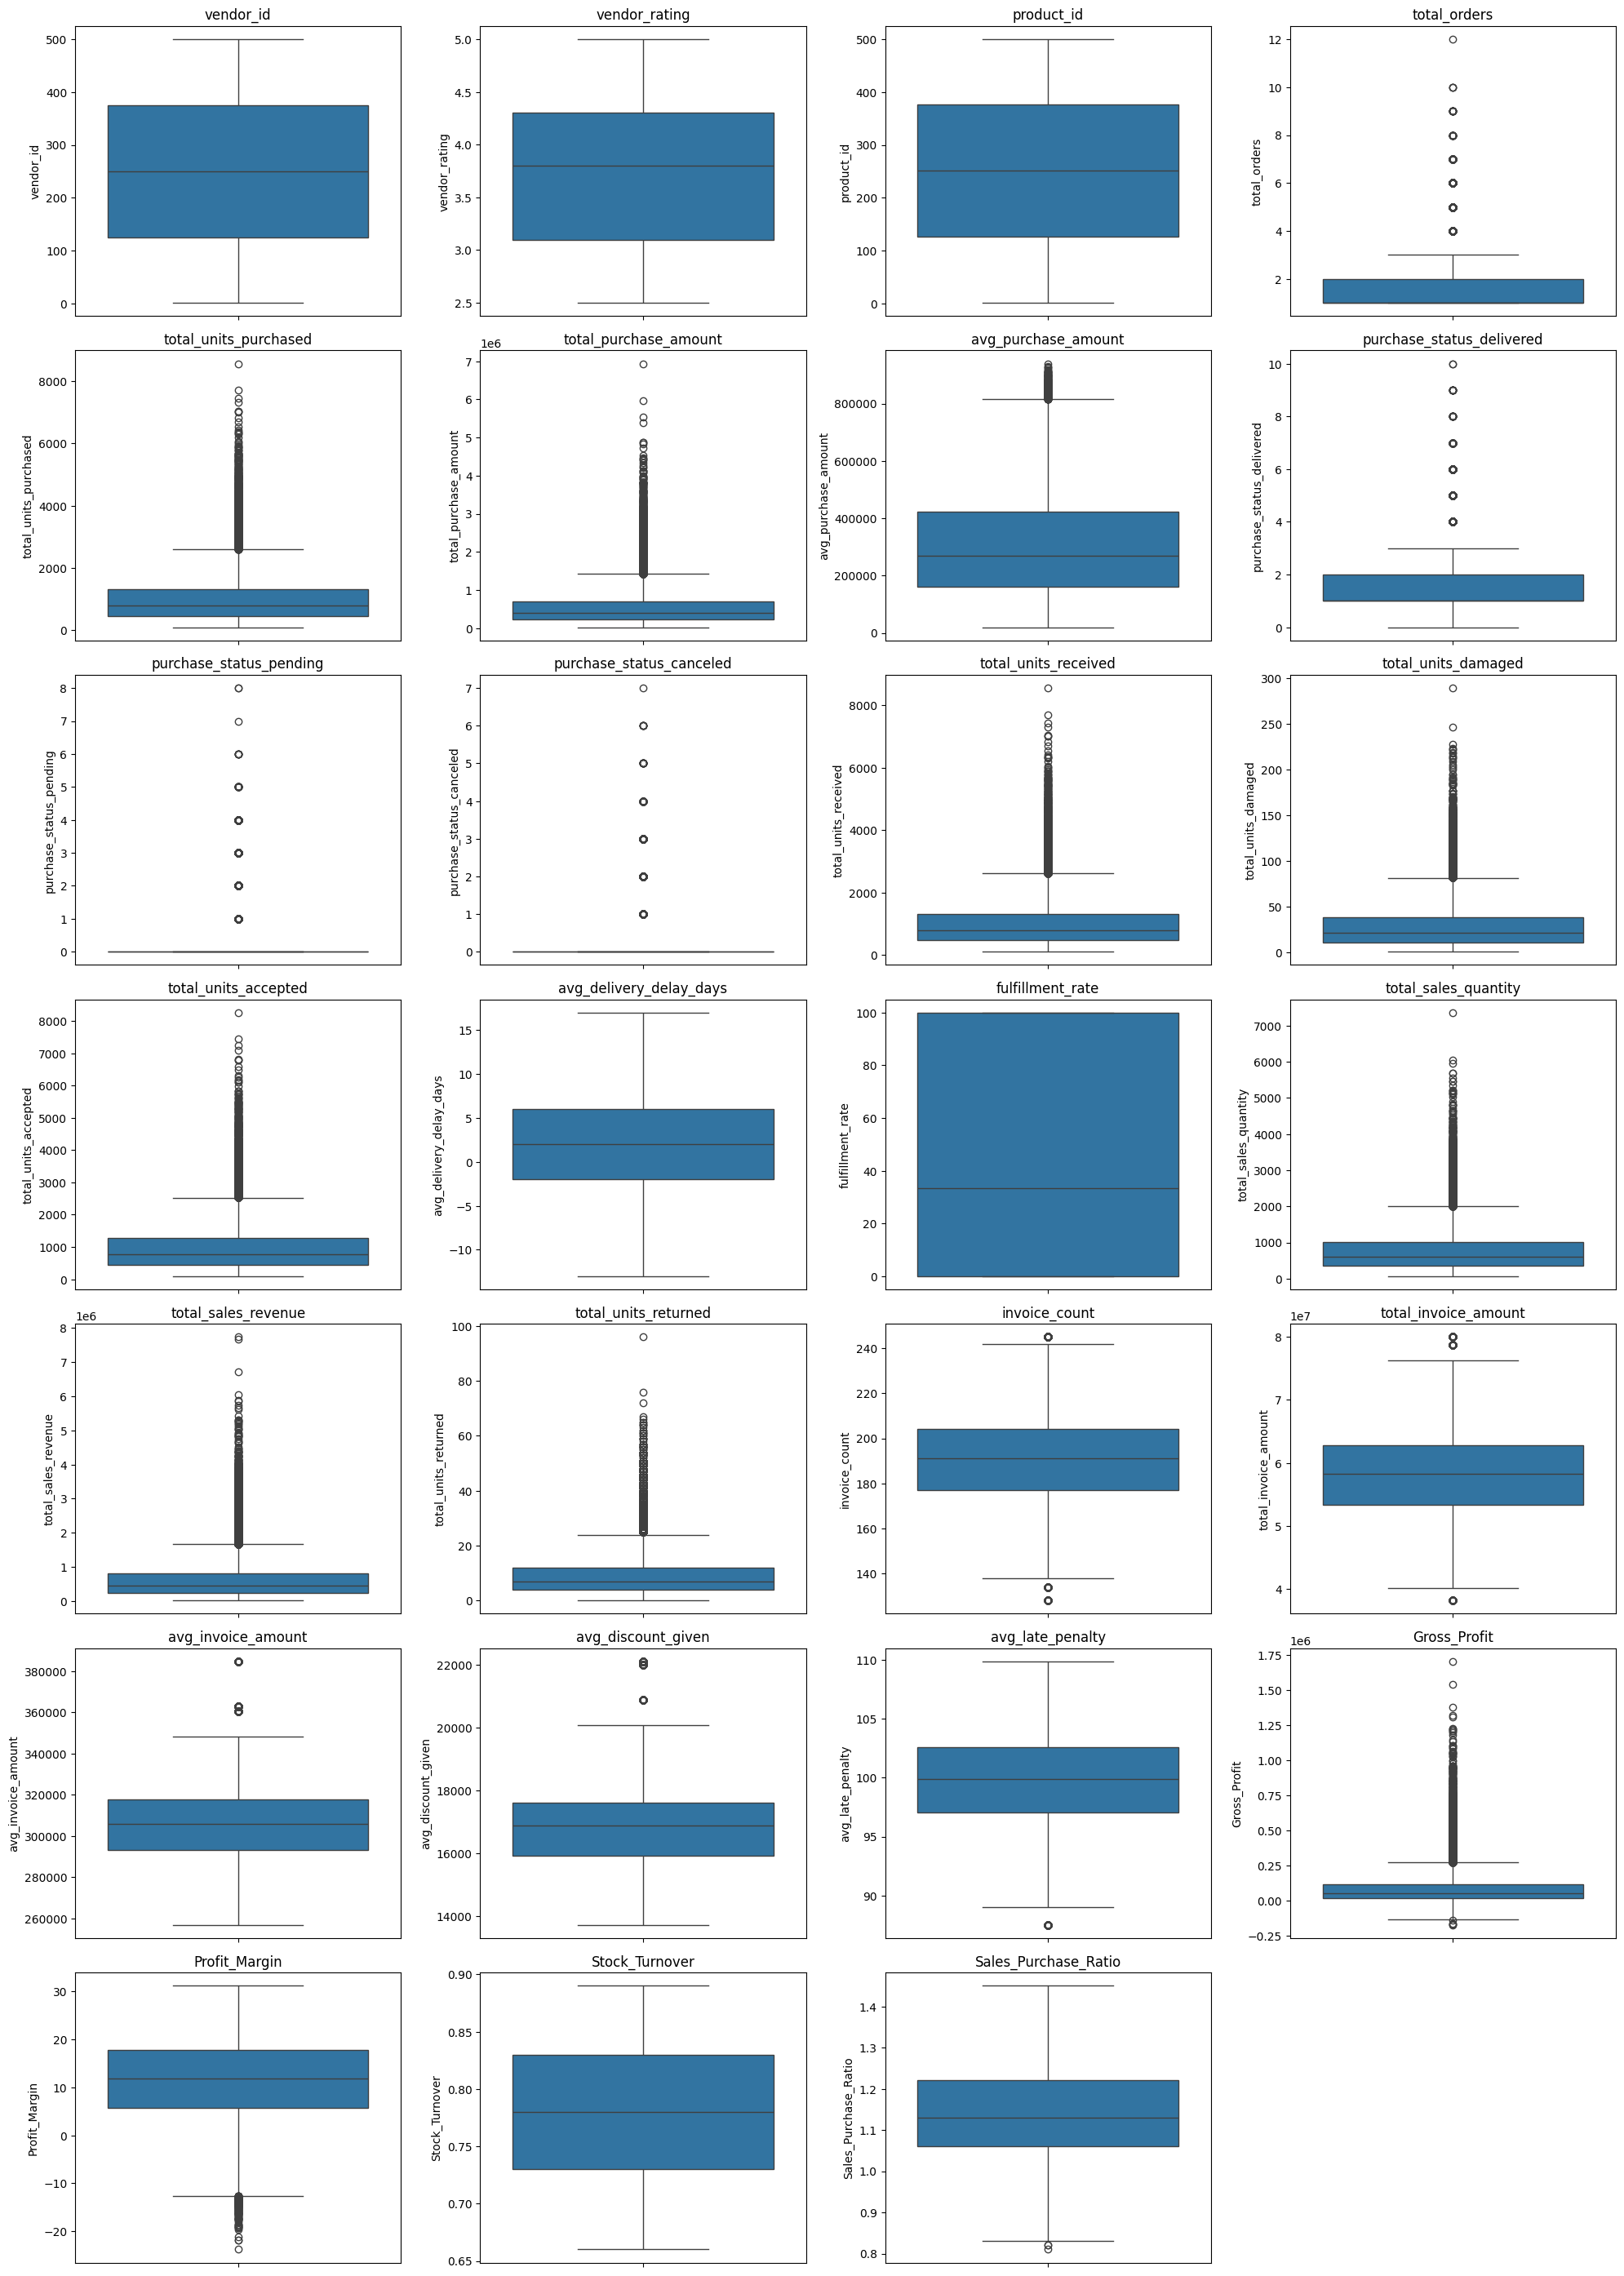

In [6]:
# Distributtion Plots for Numerical columns

numerical_cols = df.select_dtypes(include=np.number).columns
num_cols = len(numerical_cols)

# dynamically calculate grid size
n_cols = 4 # number of columns in subplots
n_rows = (num_cols + n_cols -1) // n_cols # ceil division

plt.figure(figsize=(n_cols*5,n_rows*4))
for i,col in enumerate(numerical_cols):
    plt.subplot(n_rows,n_cols,i+1) # adjust grid layout as needed
    sns.boxplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.savefig("Distributtion Box Plots for Numerical columns",dpi=600, bbox_inches='tight')
plt.show()

In [7]:
df['Gross_Profit'].sum()

np.float64(4798832422.55)

In [8]:
df['Gross_Profit'].max()

np.float64(1703582.77)

### Filter Data





In [9]:
# Let's filter data 

df = pd.read_sql_query("""SELECT *
FROM vendors_sales_summary
WHERE Gross_Profit > 0
AND Profit_Margin > 0
AND total_sales_quantity > 0""",connection)
df['vendor_name'] = df['vendor_name'].str.strip().str.title()
df

,vendor_id,vendor_name,vendor_rating,active_status,product_id,product_name,category,total_orders,total_units_purchased,total_purchase_amount,...,total_units_returned,invoice_count,total_invoice_amount,avg_invoice_amount,avg_discount_given,avg_late_penalty,Gross_Profit,Profit_Margin,Stock_Turnover,Sales_Purchase_Ratio
0,497,Rush Llc,3.3,Active,1,Philips Microwave Oven – Red,Home Appliances,5,2856,1179908.11,...,18,192,57470652.53,299326.32,17018.75,93.49,25229.27,2.09,0.68,1.02
1,493,Blackburn-Mitchell,2.8,Active,1,Philips Microwave Oven – Red,Home Appliances,2,900,397188.00,...,3,180,58417705.52,324542.81,17919.27,98.75,9796.84,2.41,0.74,1.02
2,492,Roman-Zavala,4.0,Active,1,Philips Microwave Oven – Red,Home Appliances,1,496,225789.12,...,5,228,76317991.32,334728.03,18313.40,102.10,33212.71,12.82,0.83,1.15
3,490,Arnold Ltd,3.7,Inactive,1,Philips Microwave Oven – Red,Home Appliances,2,1902,803652.06,...,23,210,62499059.31,297614.57,15573.79,100.23,217419.84,21.29,0.87,1.27
4,488,"Malone, Rowe And Weaver",3.1,Inactive,1,Philips Microwave Oven – Red,Home Appliances,3,615,277452.08,...,7,165,49452575.87,299712.58,16717.16,97.48,47077.74,14.51,0.84,1.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49862,23,"Cummings, Warner And Hudson",3.2,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,1358,399577.91,...,9,213,65065889.84,305473.66,16724.59,97.83,33611.40,7.76,0.68,1.08
49863,12,Day Llc,4.1,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,488,157780.16,...,3,187,67847601.92,362821.40,19342.97,99.64,12874.61,7.54,0.75,1.08
49864,10,"King, Brown And Booker",4.2,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,1,160,52241.60,...,1,211,65848655.12,312078.93,17292.24,106.17,6055.10,10.39,0.80,1.12
49865,8,Taylor Group,4.9,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,1,666,203243.22,...,4,245,70728666.48,288688.43,17666.80,94.96,9407.36,4.42,0.68,1.05


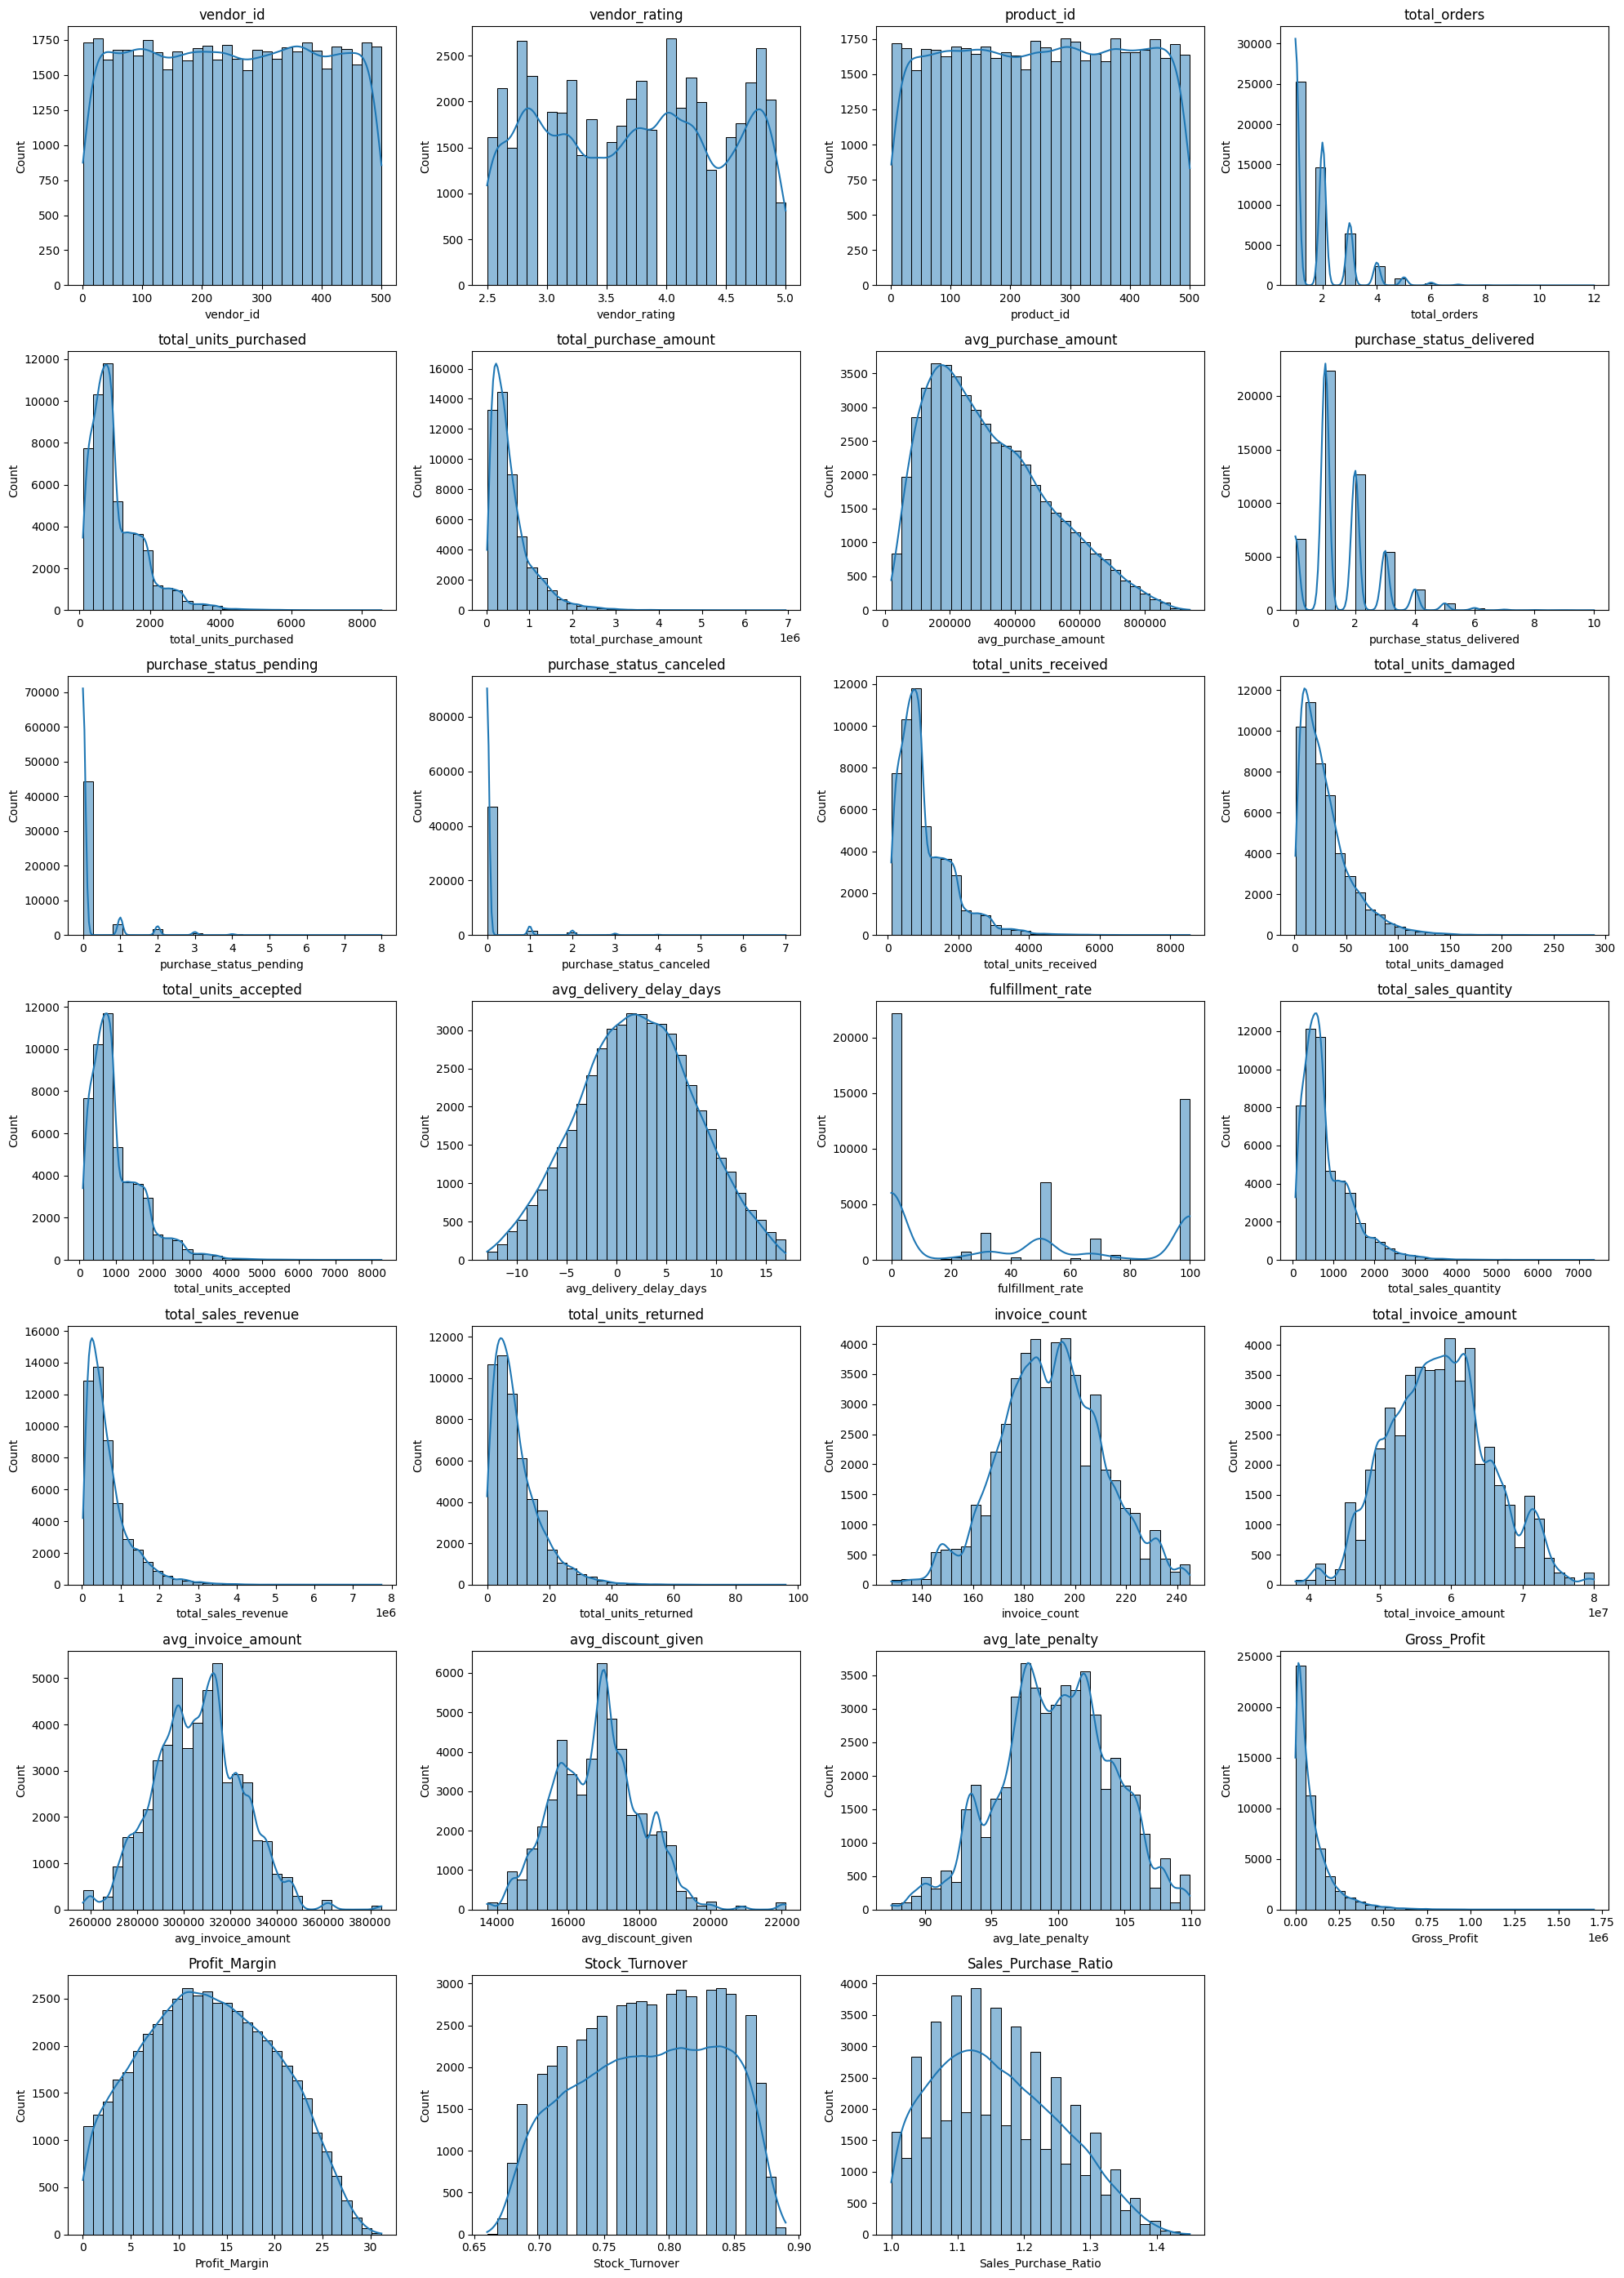

In [10]:
# Distributtion Plots for Numerical columns After Filter

numerical_cols = df.select_dtypes(include=np.number).columns
num_cols = len(numerical_cols)

# dynamically calculate grid size
n_cols = 4 # number of columns in subplots
n_rows = (num_cols + n_cols -1) // n_cols # ceil division

plt.figure(figsize=(n_cols*5,n_rows*4))
for i,col in enumerate(numerical_cols):
    plt.subplot(n_rows,n_cols,i+1) # adjust grid layout as needed
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.savefig("Distributtion Plots After Filter for Numerical columns",dpi=600, bbox_inches='tight')
plt.show()

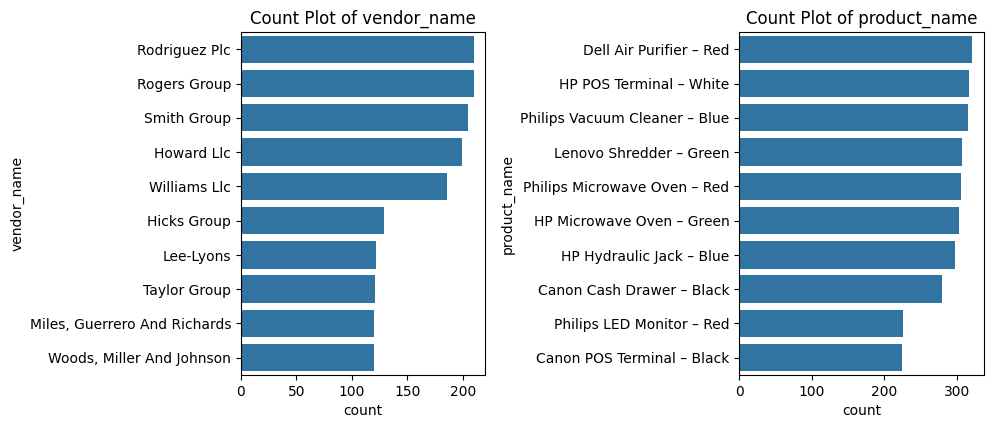

In [11]:
# Distributtion Plots for Numerical columns

categorical_cols = ["vendor_name","product_name"]
num_cols = len(numerical_cols)

# dynamically calculate grid size
n_cols = 4 # number of columns in subplots
n_rows = (num_cols + n_cols -1) // n_cols # ceil division

plt.figure(figsize=(n_cols*5,n_rows*4))
for i,col in enumerate(categorical_cols):
    plt.subplot(n_rows,n_cols,i+1) # adjust grid layout as needed
    sns.countplot(y=df[col],order=df[col].value_counts().index[:10]) # top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

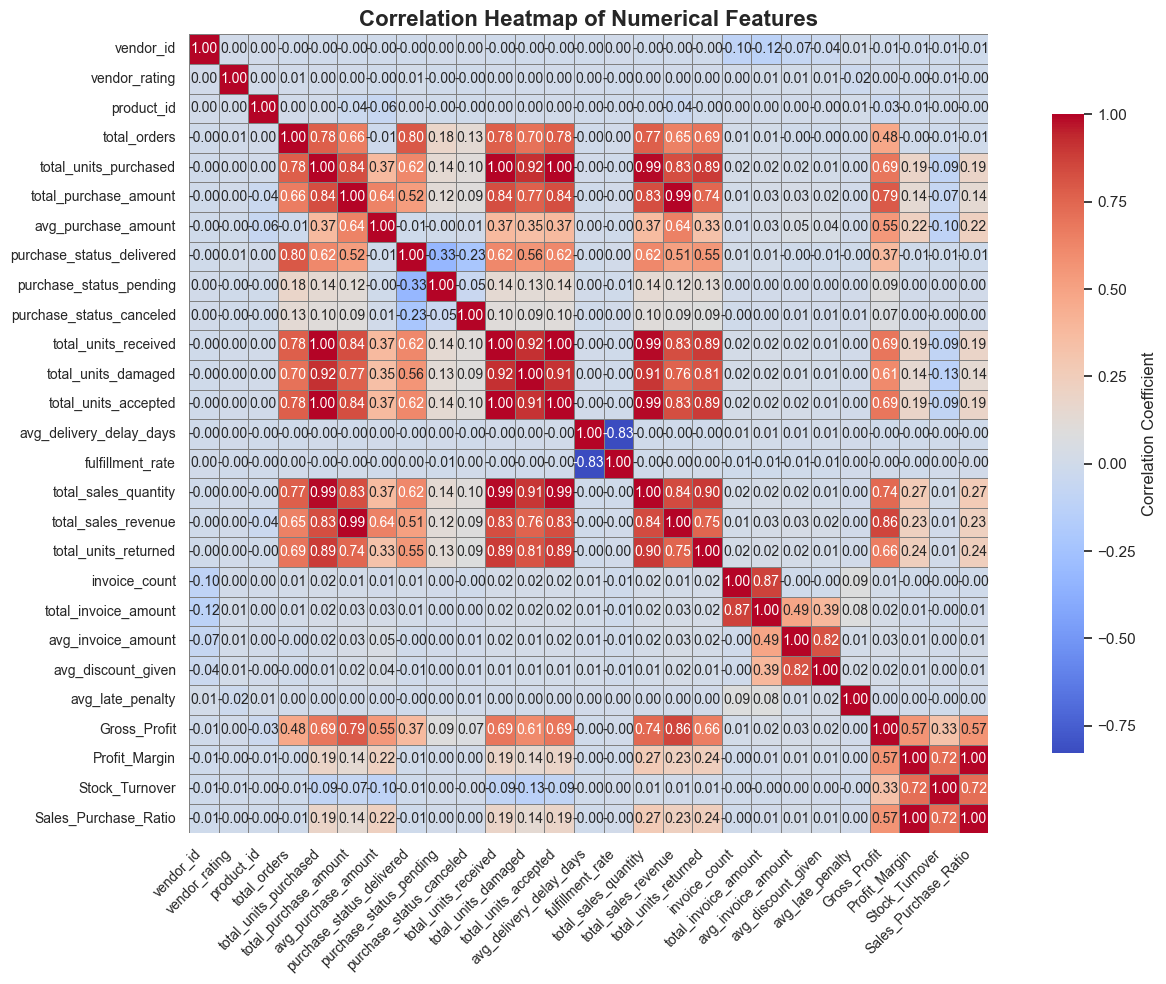

In [12]:
# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Set figure and style
plt.figure(figsize=(14, 10))
sns.set(style="white")

# Create heatmap
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
    annot_kws={"size": 10}
)

# Title and layout
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("Calculate correlation matrix",dpi=600, bbox_inches='tight')
plt.show()

In [13]:
gross = df['total_sales_revenue'] - df['total_purchase_amount']

gross

0         25229.27
1          9796.84
2         33212.71
3        217419.84
4         47077.74
           ...    
49862     33611.40
49863     12874.61
49864      6055.10
49865      9407.36
49866     49719.90
Length: 49867, dtype: float64

In [14]:
df.columns

Index(['vendor_id', 'vendor_name', 'vendor_rating', 'active_status',
       'product_id', 'product_name', 'category', 'total_orders',
       'total_units_purchased', 'total_purchase_amount', 'avg_purchase_amount',
       'purchase_status_delivered', 'purchase_status_pending',
       'purchase_status_canceled', 'total_units_received',
       'total_units_damaged', 'total_units_accepted',
       'avg_delivery_delay_days', 'fulfillment_rate', 'total_sales_quantity',
       'total_sales_revenue', 'total_units_returned', 'invoice_count',
       'total_invoice_amount', 'avg_invoice_amount', 'avg_discount_given',
       'avg_late_penalty', 'Gross_Profit', 'Profit_Margin', 'Stock_Turnover',
       'Sales_Purchase_Ratio'],
      dtype='object')

In [15]:
gross.sum()

np.float64(4874516422.58)

### Data Analysis

#### Indentify that brands need promotional and pricing adjustments which exhibit lower sales performance but higher profit margins.

In [16]:
brand_performance = df.groupby('product_name').agg({
    'total_sales_revenue' : 'sum',
    'Profit_Margin':'mean'}).reset_index()

brand_performance

,product_name,total_sales_revenue,Profit_Margin
0,Apple Air Purifier – Blue,7.849907e+07,12.858529
1,Apple Air Purifier – Red,7.294022e+07,13.423529
2,Apple Barcode Scanner – Black,9.004703e+07,13.396154
3,Apple Barcode Scanner – Red,1.037711e+08,13.457647
4,Apple Barcode Scanner – White,4.527735e+07,12.775833
...,...,...,...
430,Sony Smartwatch – Black,8.665392e+07,12.532738
431,Sony Smartwatch – Blue,1.136576e+08,13.537549
432,Sony Tablet – Black,1.039452e+08,13.015703
433,Sony Tablet – Grey,2.902006e+07,12.657822


In [17]:
low_sales_threshold = brand_performance['total_sales_revenue'].quantile(0.15)
high_margin_threshold = brand_performance['Profit_Margin'].quantile(0.85)

In [18]:
low_sales_threshold

np.float64(37970820.633)

In [19]:
high_margin_threshold.round(2)

np.float64(13.93)

In [20]:
# Filter brands with low sales but high profit margins

target_brands = brand_performance[
    (brand_performance['total_sales_revenue'] <= low_sales_threshold) &
    (brand_performance['Profit_Margin'] >= high_margin_threshold)
        ]
print("Brands with low sales but high Profit_Margin : ")
display(target_brands.sort_values('total_sales_revenue'))

Brands with low sales but high Profit_Margin : 


,product_name,total_sales_revenue,Profit_Margin
89,Canon Barcode Scanner – Green,21314543.36,14.597356
280,Lenovo Microwave Oven – Grey,23130092.99,14.822410
97,Canon Clothing Rack – White,26254840.29,14.455234
350,Philips Welding Machine – Grey,27502575.63,14.132041
314,Philips Hydraulic Jack – Grey,28925069.40,14.317582
22,Apple Laser Printer – Blue,34358968.89,14.037850
53,Asus Cash Drawer – Green,35187382.97,13.970753
283,Lenovo Power Drill – Green,35239972.75,14.132967
298,Philips Air Purifier – Grey,37903466.46,14.397955


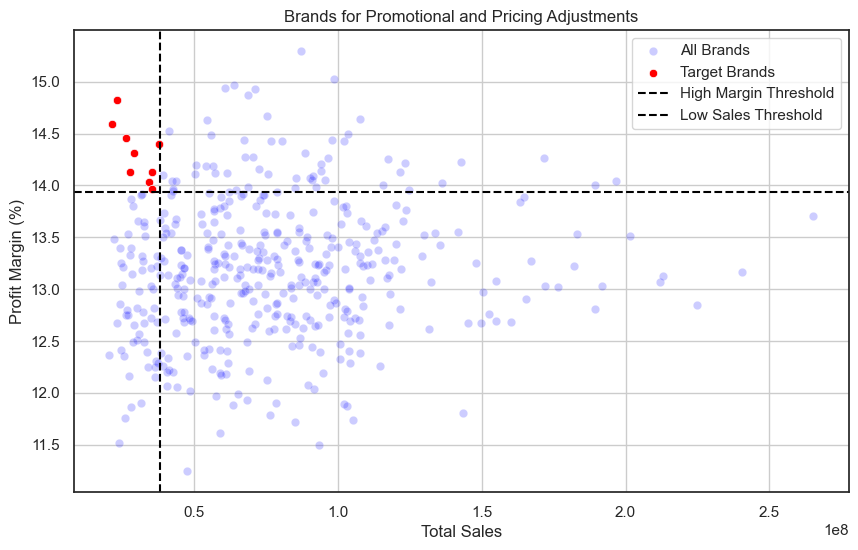

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(data = brand_performance,x = 'total_sales_revenue',y = 'Profit_Margin', color = "blue", label = "All Brands", alpha = 0.2)
sns.scatterplot(data = target_brands,x = 'total_sales_revenue',y = 'Profit_Margin', color = "red", label = "Target Brands")

plt.axhline(high_margin_threshold,linestyle="--",color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold,linestyle="--",color='black',label='Low Sales Threshold')

plt.xlabel("Total Sales")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional and Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.savefig("Brands for Promotional and Pricing Adjustments",dpi=600, bbox_inches='tight')
plt.show()

### Which vendors and brands demonstratethe highest sales performance?

In [22]:
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)

In [23]:
# Top Vendors & Brands by sales performance
top_vendors = df.groupby("vendor_name")["total_sales_revenue"].sum().nlargest(10)
top_brands = df.groupby("product_name")["total_sales_revenue"].sum().nlargest(10)

top_vendors

vendor_name
Rogers Group              1.460181e+08
Rodriguez Plc             1.411284e+08
Smith Group               1.399376e+08
Howard Llc                1.266604e+08
Williams Llc              1.253101e+08
Hicks Group               9.616810e+07
Williams Group            9.365929e+07
Taylor Group              9.279859e+07
Smith, Pitts And Green    8.999734e+07
Peck, Wells And Rogers    8.772835e+07
Name: total_sales_revenue, dtype: float64

In [24]:
top_brands

product_name
Canon Cash Drawer – Black       2.652835e+08
HP POS Terminal – White         2.404216e+08
Dell Air Purifier – Red         2.247726e+08
Philips LED Monitor – Red       2.130283e+08
HP Hydraulic Jack – Blue        2.118511e+08
HP Shredder – Blue              2.014139e+08
Samsung Cash Drawer – Black     1.968152e+08
Apple Microwave Oven – Grey     1.918559e+08
Asus Barcode Scanner – Grey     1.894921e+08
Philips Microwave Oven – Red    1.891947e+08
Name: total_sales_revenue, dtype: float64

In [25]:
top_brands.apply(lambda x : format_dollars(x))

product_name
Canon Cash Drawer – Black       265.28M
HP POS Terminal – White         240.42M
Dell Air Purifier – Red         224.77M
Philips LED Monitor – Red       213.03M
HP Hydraulic Jack – Blue        211.85M
HP Shredder – Blue              201.41M
Samsung Cash Drawer – Black     196.82M
Apple Microwave Oven – Grey     191.86M
Asus Barcode Scanner – Grey     189.49M
Philips Microwave Oven – Red    189.19M
Name: total_sales_revenue, dtype: object

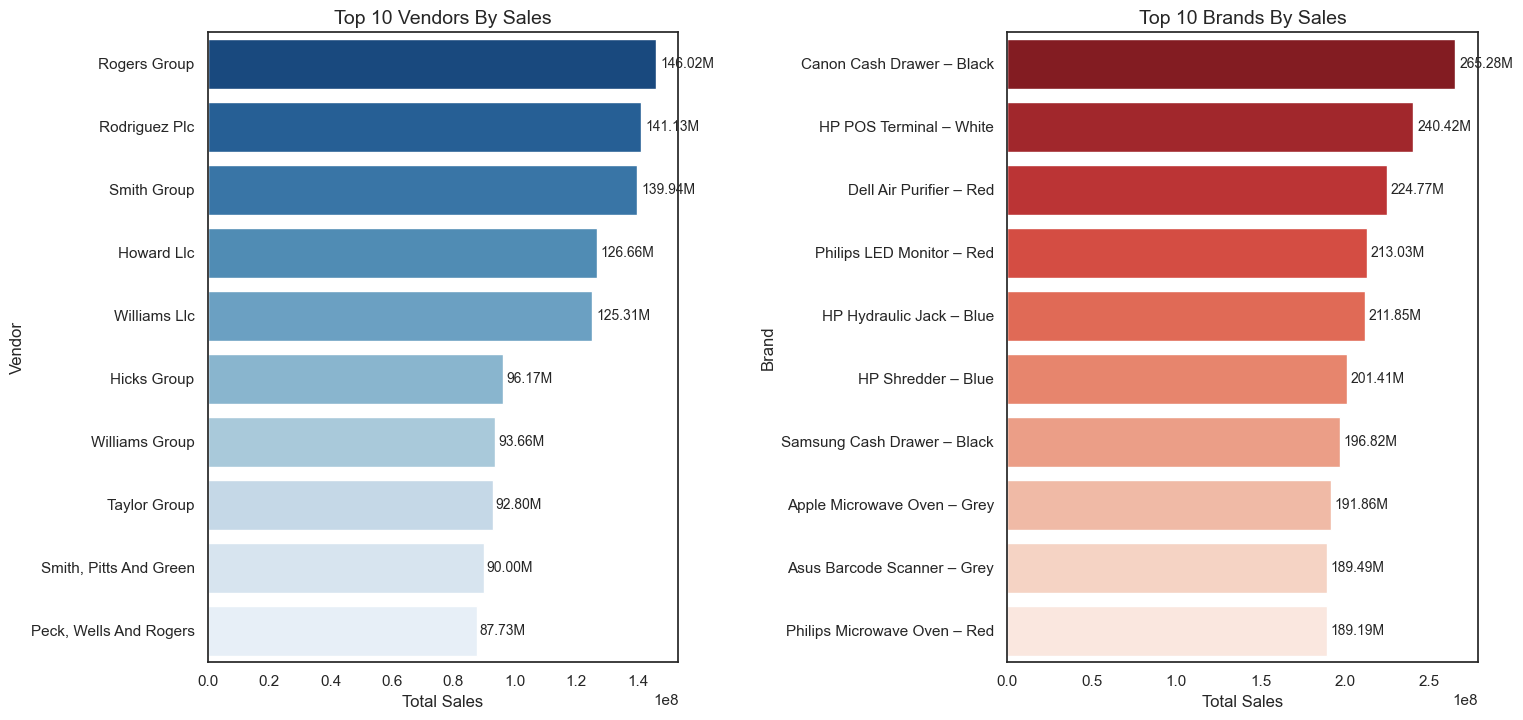

In [26]:
plt.figure(figsize=(16, 8))  # Wider figure

# --- Plot 1: Top Vendors ---
plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    y=top_vendors.index,
    x=top_vendors.values,
    hue=top_vendors.index,
    palette="Blues_r",
    dodge=False,
    legend=False
)
plt.title("Top 10 Vendors By Sales", fontsize=14)
ax1.set_xlabel("Total Sales", fontsize=12)
ax1.set_ylabel("Vendor", fontsize=12)

# Annotate values
for bar in ax1.patches:
    ax1.text(
        bar.get_width() + (bar.get_width() * 0.01),
        bar.get_y() + bar.get_height() / 2,
        format_dollars(bar.get_width()),
        ha="left", va="center", fontsize=10
    )

# --- Plot 2: Top Brands ---
plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    y=top_brands.index.astype(str),
    x=top_brands.values,
    hue=top_brands.index.astype(str),
    palette="Reds_r",
    dodge=False,
    legend=False
)
plt.title("Top 10 Brands By Sales", fontsize=14)
ax2.set_xlabel("Total Sales", fontsize=12)
ax2.set_ylabel("Brand", fontsize=12)

# Annotate values
for bar in ax2.patches:
    ax2.text(
        bar.get_width() + (bar.get_width() * 0.01),
        bar.get_y() + bar.get_height() / 2,
        format_dollars(bar.get_width()),
        ha="left", va="center", fontsize=10
    )

# Final spacing adjustment
plt.tight_layout(pad=3.0)
plt.show()

### Which Vendors contribute the most total purchase amount

In [27]:
Vendor_Performance = df.groupby("vendor_name").agg({
    'total_purchase_amount' : 'sum',
    'Gross_Profit' : 'sum',
    'total_sales_revenue' : 'sum'
}).reset_index()

Vendor_Performance

,vendor_name,total_purchase_amount,Gross_Profit,total_sales_revenue
0,"Acevedo, Nelson And Mcdowell",48137051.69,8175719.36,56312771.05
1,Adams And Sons,55403031.67,9944653.12,65347684.79
2,Adams Inc,51030679.53,9492590.97,60523270.50
3,"Adams, Harris And Ramirez",68561580.85,12366417.07,80927997.92
4,Aguilar Plc,66487122.34,11990100.47,78477222.81
...,...,...,...,...
490,Yang Ltd,57764543.26,10880054.18,68644597.44
491,"Young, Bowman And Davis",60926585.03,10554081.35,71480666.38
492,"Young, Murray And Pacheco",57998506.97,9267577.08,67266084.05
493,Young-Barr,56393636.78,10543625.80,66937262.58


In [28]:
Vendor_Performance['Purchase_Contribution %'] = Vendor_Performance['total_purchase_amount'] / Vendor_Performance['total_purchase_amount'].sum()

In [29]:
Vendor_Performance = Vendor_Performance.sort_values('Purchase_Contribution %',ascending=False).round(3)

In [30]:
Vendor_Performance

,vendor_name,total_purchase_amount,Gross_Profit,total_sales_revenue,Purchase_Contribution %
374,Rogers Group,1.238860e+08,22132150.36,1.460181e+08,0.004
372,Rodriguez Plc,1.197220e+08,21406415.21,1.411284e+08,0.004
409,Smith Group,1.189871e+08,20950521.32,1.399376e+08,0.004
196,Howard Llc,1.083793e+08,18281131.67,1.266604e+08,0.004
475,Williams Llc,1.075044e+08,17805716.79,1.253101e+08,0.004
...,...,...,...,...,...
159,"Haney, Buchanan And Ford",3.944652e+07,6569711.57,4.601623e+07,0.001
338,"Preston, Glover And Riley",3.914265e+07,6398085.90,4.554073e+07,0.001
245,Larson Ltd,3.817662e+07,6518729.94,4.469535e+07,0.001
485,Wolf-Romero,3.794251e+07,6917147.78,4.485965e+07,0.001


In [31]:
# Top 10 Vendors 

top_vendors = Vendor_Performance.head(10).copy()

top_vendors['total_purchase_amount'] = top_vendors['total_purchase_amount'].apply(format_dollars)
top_vendors['Gross_Profit'] = top_vendors['Gross_Profit'].apply(format_dollars)
top_vendors['total_sales_revenue'] = top_vendors['total_sales_revenue'].apply(format_dollars)

top_vendors

,vendor_name,total_purchase_amount,Gross_Profit,total_sales_revenue,Purchase_Contribution %
374,Rogers Group,123.89M,22.13M,146.02M,0.004
372,Rodriguez Plc,119.72M,21.41M,141.13M,0.004
409,Smith Group,118.99M,20.95M,139.94M,0.004
196,Howard Llc,108.38M,18.28M,126.66M,0.004
475,Williams Llc,107.50M,17.81M,125.31M,0.004
177,Hicks Group,82.36M,13.80M,96.17M,0.003
474,Williams Group,79.86M,13.80M,93.66M,0.003
432,Taylor Group,78.54M,14.26M,92.80M,0.003
416,"Smith, Pitts And Green",76.10M,13.90M,90.00M,0.003
105,Dunn Plc,74.75M,11.71M,86.47M,0.003


In [32]:
top_vendors['Purchase_Contribution %'].sum().round(2)

np.float64(0.04)

### Does purchasing in bulk reduce the unit price and what is the optimal purchase volume for cost saving?

In [33]:
df['unit_purchase_price'] = df['total_purchase_amount'] / df['total_units_purchased']

In [34]:
# Ensure the column is numeric
df['total_units_purchased'] = pd.to_numeric(df['total_units_purchased'], errors='coerce')

# Now apply qcut
df['OrderSize'] = pd.qcut(df['total_units_purchased'], q=3, labels=["Small", "Medium", "Large"])


In [35]:
df

,vendor_id,vendor_name,vendor_rating,active_status,product_id,product_name,category,total_orders,total_units_purchased,total_purchase_amount,...,total_invoice_amount,avg_invoice_amount,avg_discount_given,avg_late_penalty,Gross_Profit,Profit_Margin,Stock_Turnover,Sales_Purchase_Ratio,unit_purchase_price,OrderSize
0,497,Rush Llc,3.3,Active,1,Philips Microwave Oven – Red,Home Appliances,5,2856,1179908.11,...,57470652.53,299326.32,17018.75,93.49,25229.27,2.09,0.68,1.02,413.133092,Large
1,493,Blackburn-Mitchell,2.8,Active,1,Philips Microwave Oven – Red,Home Appliances,2,900,397188.00,...,58417705.52,324542.81,17919.27,98.75,9796.84,2.41,0.74,1.02,441.320000,Medium
2,492,Roman-Zavala,4.0,Active,1,Philips Microwave Oven – Red,Home Appliances,1,496,225789.12,...,76317991.32,334728.03,18313.40,102.10,33212.71,12.82,0.83,1.15,455.220000,Small
3,490,Arnold Ltd,3.7,Inactive,1,Philips Microwave Oven – Red,Home Appliances,2,1902,803652.06,...,62499059.31,297614.57,15573.79,100.23,217419.84,21.29,0.87,1.27,422.530000,Large
4,488,"Malone, Rowe And Weaver",3.1,Inactive,1,Philips Microwave Oven – Red,Home Appliances,3,615,277452.08,...,49452575.87,299712.58,16717.16,97.48,47077.74,14.51,0.84,1.17,451.141593,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49862,23,"Cummings, Warner And Hudson",3.2,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,1358,399577.91,...,65065889.84,305473.66,16724.59,97.83,33611.40,7.76,0.68,1.08,294.239993,Large
49863,12,Day Llc,4.1,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,488,157780.16,...,67847601.92,362821.40,19342.97,99.64,12874.61,7.54,0.75,1.08,323.320000,Small
49864,10,"King, Brown And Booker",4.2,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,1,160,52241.60,...,65848655.12,312078.93,17292.24,106.17,6055.10,10.39,0.80,1.12,326.510000,Small
49865,8,Taylor Group,4.9,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,1,666,203243.22,...,70728666.48,288688.43,17666.80,94.96,9407.36,4.42,0.68,1.05,305.170000,Medium


In [36]:
df.groupby('OrderSize')[['unit_purchase_price']].mean()

C:\Users\rahul\AppData\Local\Temp\ipykernel_9976\82973613.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('OrderSize')[['unit_purchase_price']].mean()


,unit_purchase_price
OrderSize,
Small,579.969472
Medium,552.980466
Large,545.755511


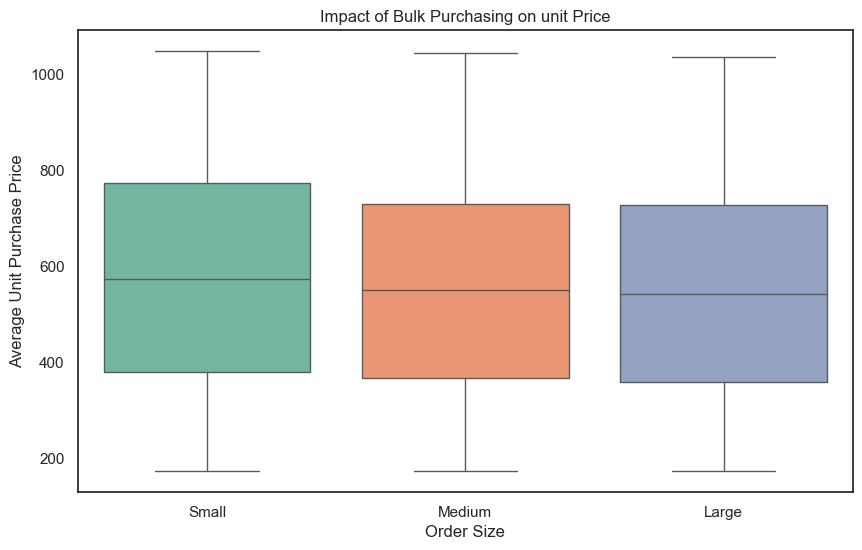

In [37]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df,x="OrderSize",y="unit_purchase_price",palette="Set2",hue='OrderSize',legend=False)
plt.title("Impact of Bulk Purchasing on unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

### Which vendor have low inventory turnover, indicating excess stock and slow-moving turnover?

In [38]:
df[df['Stock_Turnover']<1].groupby('vendor_name')[['Stock_Turnover']].mean().sort_values('Stock_Turnover',ascending=True).head(10)

,Stock_Turnover
vendor_name,
Garcia-Patel,0.767327
Osborne-Wilkins,0.767753
Schultz Inc,0.769009
Tran Ltd,0.769386
Reed-Rollins,0.771250
"Fuller, Mason And Jordan",0.771650
Prince-Bullock,0.771845
"Winters, West And Johnson",0.772212
Bradley-James,0.772347


### How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [39]:
df['unsold_inventory_value'] = (df['total_units_purchased'] - df['total_sales_quantity']) * df['unit_purchase_price']
print("Total Unsold Capital : ",format_dollars(df['unsold_inventory_value'].sum()))

Total Unsold Capital :  6266.21M


In [40]:
# Aggregate Capital Locked per Vendors
inventory_value_per_vendor = df.groupby("vendor_name")['unsold_inventory_value'].sum().reset_index()

# Sort Vendors with the highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by='unsold_inventory_value',ascending=False)
inventory_value_per_vendor['unsold_inventory_value'] = inventory_value_per_vendor['unsold_inventory_value'].apply(format_dollars)
inventory_value_per_vendor.head(10)

,vendor_name,unsold_inventory_value
374,Rogers Group,26.13M
409,Smith Group,25.75M
372,Rodriguez Plc,25.02M
475,Williams Llc,23.95M
196,Howard Llc,23.72M
177,Hicks Group,18.37M
474,Williams Group,17.50M
440,Tran Ltd,17.36M
341,Prince-Bullock,17.04M
214,"Jimenez, Martinez And Strong",16.75M


### Investigate the profitability variance between high-performing and low-performing vendors.

In [41]:
threshold = df['Profit_Margin'].median()

high_perf = df[df['Profit_Margin'] > threshold]
low_perf = df[df['Profit_Margin'] <= threshold]

high_perf

,vendor_id,vendor_name,vendor_rating,active_status,product_id,product_name,category,total_orders,total_units_purchased,total_purchase_amount,...,avg_invoice_amount,avg_discount_given,avg_late_penalty,Gross_Profit,Profit_Margin,Stock_Turnover,Sales_Purchase_Ratio,unit_purchase_price,OrderSize,unsold_inventory_value
3,490,Arnold Ltd,3.7,Inactive,1,Philips Microwave Oven – Red,Home Appliances,2,1902,803652.06,...,297614.57,15573.79,100.23,217419.84,21.29,0.87,1.27,422.530000,Large,101407.200000
4,488,"Malone, Rowe And Weaver",3.1,Inactive,1,Philips Microwave Oven – Red,Home Appliances,3,615,277452.08,...,299712.58,16717.16,97.48,47077.74,14.51,0.84,1.17,451.141593,Small,43309.592976
7,480,Dorsey Llc,3.1,Active,1,Philips Microwave Oven – Red,Home Appliances,4,2124,878337.75,...,272440.27,15499.19,99.77,170810.99,16.28,0.80,1.19,413.530014,Large,174923.195975
9,475,Rogers Group,5.0,Active,1,Philips Microwave Oven – Red,Home Appliances,7,3293,1409109.14,...,314517.33,17148.03,98.59,267165.73,15.94,0.82,1.19,427.910459,Large,247760.155500
11,466,Baird Llc,3.4,Active,1,Philips Microwave Oven – Red,Home Appliances,1,600,241500.00,...,319087.01,17147.70,96.02,36996.77,13.28,0.74,1.15,402.500000,Small,61582.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49853,69,Williams Llc,3.7,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,1,933,272538.62,...,332989.45,18826.31,94.02,66197.15,19.54,0.78,1.24,292.109989,Medium,59590.437814
49858,46,"Fuller, Conley And Blake",2.9,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,1065,328087.00,...,310292.68,18556.65,101.28,56155.28,14.61,0.77,1.17,308.062911,Medium,75475.413146
49859,45,Ward Plc,2.7,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,3,2187,653322.52,...,330768.84,17993.50,102.97,181200.61,21.71,0.80,1.28,298.730005,Large,127557.711952
49861,24,Williams-Johnson,2.6,Active,500,Philips Microwave Oven – Grey,Home Appliances,1,990,288693.91,...,334634.87,19031.06,102.35,44092.02,13.25,0.72,1.15,291.610010,Medium,81650.802828


In [42]:
threshold

np.float64(13.03)

In [43]:
low_perf

,vendor_id,vendor_name,vendor_rating,active_status,product_id,product_name,category,total_orders,total_units_purchased,total_purchase_amount,...,avg_invoice_amount,avg_discount_given,avg_late_penalty,Gross_Profit,Profit_Margin,Stock_Turnover,Sales_Purchase_Ratio,unit_purchase_price,OrderSize,unsold_inventory_value
0,497,Rush Llc,3.3,Active,1,Philips Microwave Oven – Red,Home Appliances,5,2856,1179908.11,...,299326.32,17018.75,93.49,25229.27,2.09,0.68,1.02,413.133092,Large,374298.581113
1,493,Blackburn-Mitchell,2.8,Active,1,Philips Microwave Oven – Red,Home Appliances,2,900,397188.00,...,324542.81,17919.27,98.75,9796.84,2.41,0.74,1.02,441.320000,Medium,102386.240000
2,492,Roman-Zavala,4.0,Active,1,Philips Microwave Oven – Red,Home Appliances,1,496,225789.12,...,334728.03,18313.40,102.10,33212.71,12.82,0.83,1.15,455.220000,Small,38693.700000
5,484,Turner-Flores,2.7,Active,1,Philips Microwave Oven – Red,Home Appliances,2,1534,618938.31,...,309463.43,16860.67,103.09,43531.25,6.57,0.70,1.07,403.479993,Large,187214.716975
6,482,"Brown, Collins And Schaefer",4.2,Active,1,Philips Microwave Oven – Red,Home Appliances,2,1804,711461.50,...,315450.11,17609.68,100.56,44811.44,5.93,0.69,1.06,394.379989,Large,218092.133869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49860,26,Parker Group,4.7,Active,500,Philips Microwave Oven – Grey,Home Appliances,5,3676,1146327.47,...,319321.10,17027.31,96.84,91324.33,7.38,0.73,1.08,311.840987,Large,313400.192424
49862,23,"Cummings, Warner And Hudson",3.2,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,1358,399577.91,...,305473.66,16724.59,97.83,33611.40,7.76,0.68,1.08,294.239993,Large,127700.156804
49863,12,Day Llc,4.1,Active,500,Philips Microwave Oven – Grey,Home Appliances,2,488,157780.16,...,362821.40,19342.97,99.64,12874.61,7.54,0.75,1.08,323.320000,Small,39445.040000
49864,10,"King, Brown And Booker",4.2,Inactive,500,Philips Microwave Oven – Grey,Home Appliances,1,160,52241.60,...,312078.93,17292.24,106.17,6055.10,10.39,0.80,1.12,326.510000,Small,10448.320000


In [44]:
summary = pd.DataFrame({
    "Metric": ["Total Sales Revenue", "Total Purchase Amount", "Gross Profit", "Profit Margin"],
    "High Performing Vendors": [
        high_perf['total_sales_revenue'].mean(),
        high_perf['total_purchase_amount'].mean(),
        high_perf['Gross_Profit'].mean(),
        high_perf['Profit_Margin'].mean()
    ],
    "Low Performing Vendors": [
        low_perf['total_sales_revenue'].mean(),
        low_perf['total_purchase_amount'].mean(),
        low_perf['Gross_Profit'].mean(),
        low_perf['Profit_Margin'].mean()
    ]
})
summary

,Metric,High Performing Vendors,Low Performing Vendors
0,Total Sales Revenue,785071.554398,557803.475914
1,Total Purchase Amount,633081.331297,514264.737688
2,Gross Profit,151990.223101,43538.738226
3,Profit Margin,18.948216,7.451205


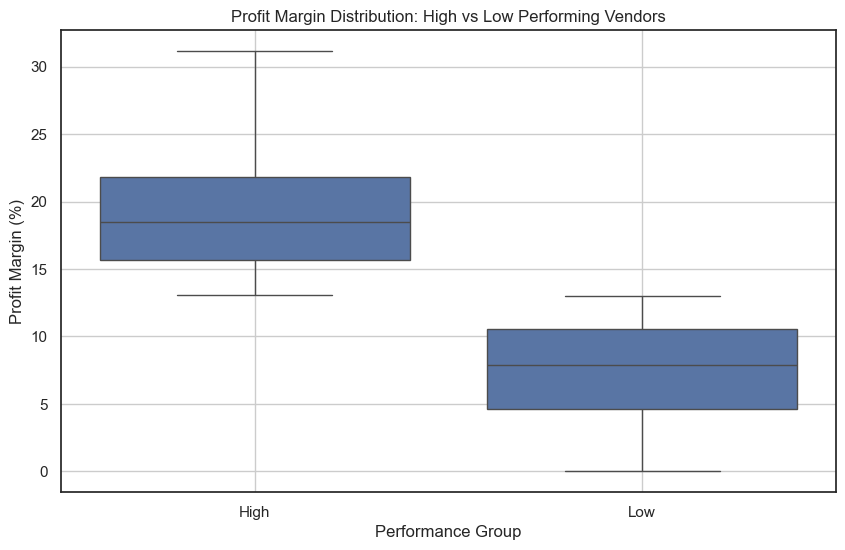

In [45]:

plt.figure(figsize=(10, 6))
sns.boxplot(x="Performance Group", y="Profit_Margin",
            data=pd.concat([
                high_perf.assign(**{"Performance Group": "High"}),
                low_perf.assign(**{"Performance Group": "Low"})
            ]))
plt.title("Profit Margin Distribution: High vs Low Performing Vendors")
plt.ylabel("Profit Margin (%)")
plt.grid(True)
plt.savefig("profit_margin_confidence_intervals.png", dpi=600, bbox_inches='tight')
plt.show()